In [1]:
%cd ../

/home/hoanghu/projects/Food-Waste-Optimization/experiments_hoangle


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import TargetEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import KFold

from utils import Paths

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# Load data and resources

## Load related dim table

In [4]:
dim_lunches = pd.read_excel(Paths.dim_lucnhes(), index_col=None, parse_dates=['date'])
dim_lunches.head()

,date,restaurant,category,meal,pcs
0,2023-01-02,Chemicum,fish,Kalapuikot tillikermaviilikast,78
1,2023-01-02,Chemicum,meat,Uunimakkaraa,165
2,2023-01-02,Chemicum,vegan,Marokkolainen linssipata,84
3,2023-01-03,Chemicum,fish,Herkkulohipihvit,105
4,2023-01-03,Chemicum,fish,Kalapuikot tillikermaviilikast,52


## Load embeddings

In [5]:
map_dish2embd = np.load(Paths().res_dish2embd(), allow_pickle=True).item()
map_cat2embd = np.load(Paths().res_cat2embd(), allow_pickle=True).item()

# Encode features (and target)

In [6]:
cols_X = ['date', 'restaurant', 'category', 'meal']
col_y = 'pcs'

X = dim_lunches[cols_X].copy()
y = dim_lunches[col_y].copy()

### Apply encoding to 'y'

Sep 12: MinMax

In [7]:
scaler_tgt = MinMaxScaler()

y_scaled = pd.Series(scaler_tgt.fit_transform(y.to_numpy().reshape(-1, 1)).squeeze(), index=y.index)

### Apply cyclic encoding to 'date'

In [8]:
def get_sin_encoding(x, period: int):
    return np.sin(2 * np.pi * x / period)

def get_cos_encoding(x, period: int):
    return np.cos(2 * np.pi * x / period)    

In [9]:
X['weekday_sin'] = get_sin_encoding(X['date'].dt.weekday, 7)
X['weekday_cos'] = get_cos_encoding(X['date'].dt.weekday, 7)

X['day_sin'] = get_sin_encoding(X['date'].dt.day, 30)
X['day_cos'] = get_cos_encoding(X['date'].dt.day, 30)

X['month_sin'] = get_sin_encoding(X['date'].dt.month, 12)
X['month_cos'] = get_cos_encoding(X['date'].dt.month, 12)

X.head()

,date,restaurant,category,meal,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos
0,2023-01-02,Chemicum,fish,Kalapuikot tillikermaviilikast,0.000000,1.00000,0.406737,0.913545,0.5,0.866025
1,2023-01-02,Chemicum,meat,Uunimakkaraa,0.000000,1.00000,0.406737,0.913545,0.5,0.866025
2,2023-01-02,Chemicum,vegan,Marokkolainen linssipata,0.000000,1.00000,0.406737,0.913545,0.5,0.866025
3,2023-01-03,Chemicum,fish,Herkkulohipihvit,0.781831,0.62349,0.587785,0.809017,0.5,0.866025
4,2023-01-03,Chemicum,fish,Kalapuikot tillikermaviilikast,0.781831,0.62349,0.587785,0.809017,0.5,0.866025


### Apply encoding to 'restaurant'

Sep 11: Use 'TargetEncoding'

In [10]:
enc_target = TargetEncoder(target_type='continuous')

X['restaurant_enc'] = enc_target.fit_transform(X[['restaurant']], y_scaled).ravel()

X.head()

,date,restaurant,category,meal,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos,restaurant_enc
0,2023-01-02,Chemicum,fish,Kalapuikot tillikermaviilikast,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.246947
1,2023-01-02,Chemicum,meat,Uunimakkaraa,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.242445
2,2023-01-02,Chemicum,vegan,Marokkolainen linssipata,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.249437
3,2023-01-03,Chemicum,fish,Herkkulohipihvit,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.246947
4,2023-01-03,Chemicum,fish,Kalapuikot tillikermaviilikast,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.249437


### Apply encoding for 'category'

Sep 11: Use TargetEncoding

In [11]:
enc_target = TargetEncoder(target_type='continuous')

X['cat_enc'] = enc_target.fit_transform(X[['category']], y_scaled).ravel()

X.head()

,date,restaurant,category,meal,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos,restaurant_enc,cat_enc
0,2023-01-02,Chemicum,fish,Kalapuikot tillikermaviilikast,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.246947,0.167556
1,2023-01-02,Chemicum,meat,Uunimakkaraa,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.242445,0.103175
2,2023-01-02,Chemicum,vegan,Marokkolainen linssipata,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.249437,0.121216
3,2023-01-03,Chemicum,fish,Herkkulohipihvit,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.246947,0.167556
4,2023-01-03,Chemicum,fish,Kalapuikot tillikermaviilikast,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.249437,0.164381


### Encode 'meal' 

#### Apply existing embeddings for dish name

In [12]:
X['meal_enc'] = X['meal'].map(map_dish2embd)

X.head()

,date,restaurant,category,meal,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos,restaurant_enc,cat_enc,meal_enc
0,2023-01-02,Chemicum,fish,Kalapuikot tillikermaviilikast,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.246947,0.167556,"[-41.43379, 9.393979, 7.1318316, -0.565892, 3...."
1,2023-01-02,Chemicum,meat,Uunimakkaraa,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.242445,0.103175,"[-40.699654, 24.613142, 0.649376, 1.5107197, -..."
2,2023-01-02,Chemicum,vegan,Marokkolainen linssipata,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.249437,0.121216,"[66.49696, -3.3867795, -12.494734, -7.0448966,..."
3,2023-01-03,Chemicum,fish,Herkkulohipihvit,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.246947,0.167556,"[-87.67229, 31.718786, 26.539051, 6.4697046, -..."
4,2023-01-03,Chemicum,fish,Kalapuikot tillikermaviilikast,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.249437,0.164381,"[-41.43379, 9.393979, 7.1318316, -0.565892, 3...."


# Approach 1: Apply regression models

In [13]:
feat_meal = np.vstack(X['meal_enc'].to_list())

cols_feat_meal = [f'meal_name_{i}' for i in range(feat_meal.shape[1])]

df_feat_meal = pd.DataFrame(feat_meal, columns=cols_feat_meal)

### Create 2 variants of X for different models

In [14]:
cols_X_model = [
    'weekday_sin',
    'weekday_cos',
    'day_sin',
    'day_cos',
    'month_sin',
    'month_cos',
    'restaurant_enc',
    # 'cat_enc',
    # 'meal_enc'
]

Xmodel_1 = pd.concat([
    X[cols_X_model].copy(),
    df_feat_meal
], axis=1)


# Convert cat column to type 'category'
cols_cat = [
    # 'meal_enc'
]

for col in cols_cat:
    Xmodel_1[col] = Xmodel_1[col].astype('category')

Xmodel_1.head()

,weekday_sin,weekday_cos,day_sin,day_cos,month_sin,month_cos,restaurant_enc,meal_name_0,meal_name_1,meal_name_2,...,meal_name_90,meal_name_91,meal_name_92,meal_name_93,meal_name_94,meal_name_95,meal_name_96,meal_name_97,meal_name_98,meal_name_99
0,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.246947,-41.433788,9.393979,7.131832,...,-0.464634,-0.760679,-0.415426,-1.402635,-2.390355,2.655900,-0.476949,-0.008931,-0.931314,-2.191599
1,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.242445,-40.699654,24.613142,0.649376,...,2.217119,0.235981,-0.878908,1.233570,2.431796,-0.878301,0.041990,0.555465,2.601398,0.697872
2,0.000000,1.00000,0.406737,0.913545,0.5,0.866025,0.249437,66.496964,-3.386780,-12.494734,...,1.458441,-0.125991,-2.411030,1.717922,0.677590,-0.328726,-0.552619,1.728464,-0.729374,0.004286
3,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.246947,-87.672287,31.718786,26.539051,...,-0.793361,0.096004,-0.306665,-0.674438,-0.584597,1.211040,-0.073525,-0.107445,0.131203,1.393058
4,0.781831,0.62349,0.587785,0.809017,0.5,0.866025,0.249437,-41.433788,9.393979,7.131832,...,-0.464634,-0.760679,-0.415426,-1.402635,-2.390355,2.655900,-0.476949,-0.008931,-0.931314,-2.191599


In [15]:
cols_X_model = [
    'weekday_sin',
    'weekday_cos',
    # 'day_sin',
    # 'day_cos',
    # 'month_sin',
    # 'month_cos',
    'restaurant',
    'category',
    # 'meal_enc'
]

Xmodel_2 = pd.concat([
    X[cols_X_model].copy(),
    df_feat_meal
], axis=1)

## Apply OrdinalEncode for 'restaurant' and 'category'
cols_cat = [
    'restaurant',
    'category',
    # 'meal_enc'
]

enc_ordinal = OrdinalEncoder()
Xmodel_2[cols_cat] = enc_ordinal.fit_transform(Xmodel_2[cols_cat]).astype(np.int32)

# Convert cat column to type 'category'
for col in cols_cat:
    Xmodel_2[col] = Xmodel_2[col].astype('category')

Xmodel_2.head()

,weekday_sin,weekday_cos,restaurant,category,meal_name_0,meal_name_1,meal_name_2,meal_name_3,meal_name_4,meal_name_5,...,meal_name_90,meal_name_91,meal_name_92,meal_name_93,meal_name_94,meal_name_95,meal_name_96,meal_name_97,meal_name_98,meal_name_99
0,0.000000,1.00000,0,1,-41.433788,9.393979,7.131832,-0.565892,3.618807,-6.806185,...,-0.464634,-0.760679,-0.415426,-1.402635,-2.390355,2.655900,-0.476949,-0.008931,-0.931314,-2.191599
1,0.000000,1.00000,0,2,-40.699654,24.613142,0.649376,1.510720,-0.130501,-0.649415,...,2.217119,0.235981,-0.878908,1.233570,2.431796,-0.878301,0.041990,0.555465,2.601398,0.697872
2,0.000000,1.00000,0,3,66.496964,-3.386780,-12.494734,-7.044897,-14.949359,3.503616,...,1.458441,-0.125991,-2.411030,1.717922,0.677590,-0.328726,-0.552619,1.728464,-0.729374,0.004286
3,0.781831,0.62349,0,1,-87.672287,31.718786,26.539051,6.469705,-3.148084,-7.316760,...,-0.793361,0.096004,-0.306665,-0.674438,-0.584597,1.211040,-0.073525,-0.107445,0.131203,1.393058
4,0.781831,0.62349,0,1,-41.433788,9.393979,7.131832,-0.565892,3.618807,-6.806185,...,-0.464634,-0.760679,-0.415426,-1.402635,-2.390355,2.655900,-0.476949,-0.008931,-0.931314,-2.191599


### Define models

In [16]:
models = {
    'Linear': {'model': LinearRegression(), 'X': Xmodel_1},
    'Ridge': {'model': Ridge(), 'X': Xmodel_1},
    'Lasso': {'model': Lasso(), 'X': Xmodel_1},
    'RF': {'model': RandomForestRegressor(), 'X': Xmodel_1},
    'GB': {'model': GradientBoostingRegressor(), 'X': Xmodel_1},
    'XGB': {'model': XGBRegressor(), 'X': Xmodel_1},
    'XGB-cat': {'model': XGBRegressor(tree_method="hist", enable_categorical=True), 'X': Xmodel_2},
    'CatBoost': {'model': CatBoostRegressor(verbose=False, cat_features=cols_cat), 'X': Xmodel_2},
    'LBGM': {'model': LGBMRegressor(verbose=0), 'X': Xmodel_2},
}

### Start training

In [17]:
kf = KFold(n_splits=5, shuffle=True)

In [18]:
rmse_models = []
r2_models = []

for name, model in models.items():
    print(f"Start: {name}")

    Xtrainval = model['X']
    ytrainval = y_scaled
    regressor = model['model']

    rmse_each, r2_each = [], []
    for train_idx, val_idx in kf.split(Xtrainval, ytrainval):
        regressor.fit(Xtrainval.iloc[train_idx], ytrainval.iloc[train_idx])

        y_test_pred = regressor.predict(Xtrainval.iloc[val_idx])

        rmse = root_mean_squared_error(
            scaler_tgt.inverse_transform(ytrainval.iloc[val_idx].to_numpy().reshape(-1, 1)),
            scaler_tgt.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()
        ).item()
        r2 = r2_score(
            scaler_tgt.inverse_transform(ytrainval.iloc[val_idx].to_numpy().reshape(-1, 1)),
            scaler_tgt.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()
        )

        rmse_each.append(rmse)
        r2_each.append(r2)

    rmse_models.append({'model': name, 'val': np.mean(rmse_each)})
    r2_models.append({'model': name, 'val': np.mean(r2_each)})

Start: Linear
Start: Ridge
Start: Lasso
Start: RF
Start: GB
Start: XGB
Start: XGB-cat
Start: CatBoost
Start: LBGM


### Plots metrics

In [19]:
df_rmse = pd.DataFrame.from_records(rmse_models)
df_r2 = pd.DataFrame.from_records(r2_models)

Text(0.5, 1.0, 'R2')

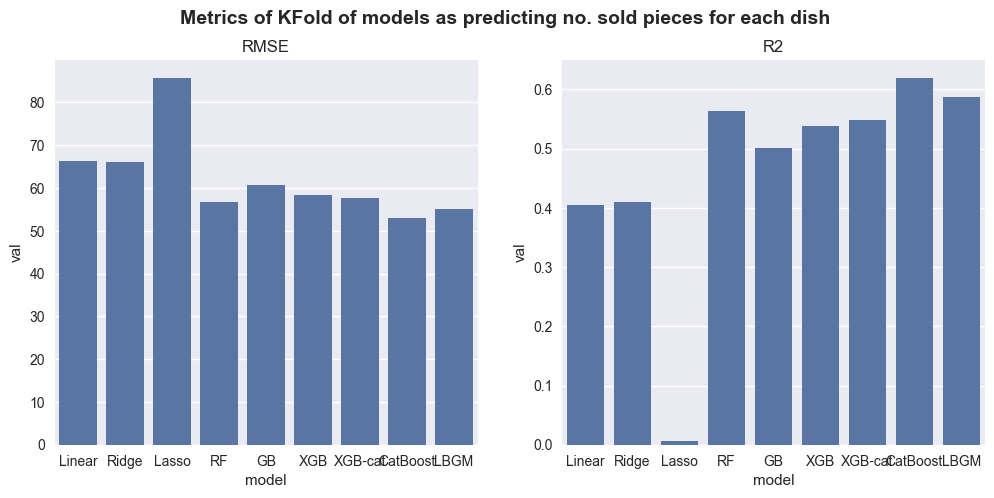

In [20]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Metrics of KFold of models as predicting no. sold pieces for each dish", fontweight='bold', fontsize=14)

ax = fig.add_subplot(121)
sns.barplot(df_rmse, x='model', y='val', ax=ax)
ax.set_title("RMSE")

ax = fig.add_subplot(122)
sns.barplot(df_r2, x='model', y='val', ax=ax)
ax.set_title("R2")

In [21]:
df_r2['val'].max()

0.6191887646255096

# Approach 2: average dish

In [34]:
rmse_each, r2_each = [], []

for train_idx, val_idx in kf.split(dim_lunches):
    # Extract training data to average no. sold pieces
    data_avg = dim_lunches.iloc[train_idx]

    avg_pcs_by_dish = data_avg.groupby(['restaurant', 'meal'])['pcs'].mean().reset_index().rename(columns={'pcs': 'pcs_train1'})
    avg_pcs_by_cat = data_avg.groupby(['restaurant', 'category'])['pcs'].mean().reset_index().rename(columns={'pcs': 'pcs_train2'})

    # Extract validating split
    data_val = dim_lunches.iloc[val_idx].copy()

    # Predict
    data_val = (
        data_val
        .merge(avg_pcs_by_dish, on=['restaurant', 'meal'], how='left')
        .merge(avg_pcs_by_cat, on=['restaurant', 'category'], how='left')
    )
    data_val['pcs_pred'] = data_val['pcs_train1'].combine_first(data_val['pcs_train2'])

    # Calculate metrics
    rmse = root_mean_squared_error(data_val['pcs'], data_val['pcs_pred']).item()
    r2 = r2_score(data_val['pcs'], data_val['pcs_pred'])

    rmse_each.append(rmse)
    r2_each.append(r2)

In [35]:
print(f"Estimated RMSE: {np.mean(rmse_each).item():.4f}")
print(f"Estimated R2  : {np.mean(r2_each).item():.4f}")

Estimated RMSE: 67.4813
Estimated R2  : 0.3827


# Tune

In [16]:
cols_X_model = [
    'weekday_sin',
    'weekday_cos',
    # 'day_sin',
    # 'day_cos',
    # 'month_sin',
    # 'month_cos',
    'restaurant',
    'category',
    # 'meal_enc'
]

Xmodel_2 = pd.concat([
    X[cols_X_model].copy(),
    df_feat_meal
], axis=1)

## Apply OrdinalEncode for 'restaurant' and 'category'
cols_cat = [
    'restaurant',
    'category',
    # 'meal_enc'
]

Xmodel_2[cols_cat] = enc_ordinal.fit_transform(Xmodel_2[cols_cat]).astype(np.int32)

# Convert cat column to type 'category'
for col in cols_cat:
    Xmodel_2[col] = Xmodel_2[col].astype('category')

Xmodel_2.head()

,weekday_sin,weekday_cos,restaurant,category,meal_name_0,meal_name_1,meal_name_2,meal_name_3,meal_name_4,meal_name_5,...,meal_name_90,meal_name_91,meal_name_92,meal_name_93,meal_name_94,meal_name_95,meal_name_96,meal_name_97,meal_name_98,meal_name_99
0,0.000000,1.00000,0,1,-41.433788,9.393979,7.131832,-0.565892,3.618807,-6.806185,...,-0.464634,-0.760679,-0.415426,-1.402635,-2.390355,2.655900,-0.476949,-0.008931,-0.931314,-2.191599
1,0.000000,1.00000,0,2,-40.699654,24.613142,0.649376,1.510720,-0.130501,-0.649415,...,2.217119,0.235981,-0.878908,1.233570,2.431796,-0.878301,0.041990,0.555465,2.601398,0.697872
2,0.000000,1.00000,0,3,66.496964,-3.386780,-12.494734,-7.044897,-14.949359,3.503616,...,1.458441,-0.125991,-2.411030,1.717922,0.677590,-0.328726,-0.552619,1.728464,-0.729374,0.004286
3,0.781831,0.62349,0,1,-87.672287,31.718786,26.539051,6.469705,-3.148084,-7.316760,...,-0.793361,0.096004,-0.306665,-0.674438,-0.584597,1.211040,-0.073525,-0.107445,0.131203,1.393058
4,0.781831,0.62349,0,1,-41.433788,9.393979,7.131832,-0.565892,3.618807,-6.806185,...,-0.464634,-0.760679,-0.415426,-1.402635,-2.390355,2.655900,-0.476949,-0.008931,-0.931314,-2.191599


In [17]:
Xtrainval = Xmodel_2
ytrainval = y_scaled

In [46]:
learning_rate = 8e-2
iterations = 1000
l2_leaf_reg = .01

regressor = CatBoostRegressor(
    verbose=False,
    cat_features=cols_cat,
    iterations=iterations,
    learning_rate=learning_rate,
    l2_leaf_reg=l2_leaf_reg
)

rmse_each, r2_each = [], []
for train_idx, val_idx in kf.split(Xtrainval, ytrainval):
    regressor.fit(Xtrainval.iloc[train_idx], ytrainval.iloc[train_idx])

    y_test_pred = regressor.predict(Xtrainval.iloc[val_idx])

    rmse = root_mean_squared_error(
        scaler_tgt.inverse_transform(ytrainval.iloc[val_idx].to_numpy().reshape(-1, 1)),
        scaler_tgt.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()
    ).item()
    r2 = r2_score(
        scaler_tgt.inverse_transform(ytrainval.iloc[val_idx].to_numpy().reshape(-1, 1)),
        scaler_tgt.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()
    )

    rmse_each.append(rmse)
    r2_each.append(r2)

print(f"rmse: {np.mean(rmse_each)}")
print(f"r2  : {np.mean(r2_each)}")

rmse: 53.76077975602099
r2  : 0.6082176061609175


# Use best model to infer data up to Jan 2025

## Create data for every dishes from Sep 2024 to Jan 2025

In [18]:
# Create list of dates
date_start = '2024-09-01'
date_end = '2025-01-01'

dates = pd.bdate_range(date_start, date_end)

# Get list of tuples of (restaurant, category, meal)
dishes = dim_lunches.groupby(by=['restaurant', 'category', 'meal']).count().reset_index().drop(columns=['date', 'pcs'])

# Create recrods
records = []
for date in dates:
    tmp = dishes.copy()
    tmp['date'] = date

    records.append(tmp)

X_pred = pd.concat(records)
X_pred.head()

,restaurant,category,meal,date
0,Chemicum,chicken,BBQ-Broilerikastiketta,2024-09-02
1,Chemicum,chicken,Broileria appelsiini-currykastikkeessa,2024-09-02
2,Chemicum,chicken,Broileria pekonikastikkeessa,2024-09-02
3,Chemicum,chicken,Broileria pestokastikkeessa,2024-09-02
4,Chemicum,chicken,Broilerinkoipea,2024-09-02


## Encode columns

In [19]:
# Encode 'date'
X_pred['weekday_sin'] = get_sin_encoding(X_pred['date'].dt.weekday, 7)
X_pred['weekday_cos'] = get_cos_encoding(X_pred['date'].dt.weekday, 7)


# Encode 'restaurant' and 'category'
cols_cat = [
    'restaurant',
    'category',
]

X_pred[cols_cat] = enc_ordinal.fit_transform(X_pred[cols_cat]).astype(np.int32)


# Encode 'meal'
feat_meal = np.vstack(X_pred['meal'].map(map_dish2embd).to_list())

cols_feat_meal = [f'meal_name_{i}' for i in range(feat_meal.shape[1])]
df_feat_meal = pd.DataFrame(feat_meal, columns=cols_feat_meal)

X_pred = pd.concat([X_pred.reset_index(), df_feat_meal], axis=1).drop(columns='index')

X_pred.head()

,restaurant,category,meal,date,weekday_sin,weekday_cos,meal_name_0,meal_name_1,meal_name_2,meal_name_3,...,meal_name_90,meal_name_91,meal_name_92,meal_name_93,meal_name_94,meal_name_95,meal_name_96,meal_name_97,meal_name_98,meal_name_99
0,0,0,BBQ-Broilerikastiketta,2024-09-02,0.0,1.0,-3.427357,-6.942751,12.151085,10.365918,...,0.768319,1.135900,1.573869,1.343605,-0.560336,1.507652,-0.454298,0.750184,-0.790916,0.873734
1,0,0,Broileria appelsiini-currykastikkeessa,2024-09-02,0.0,1.0,-30.657610,-13.181367,-5.241015,15.294079,...,-0.724043,-0.614652,-0.047335,0.761956,-0.018372,0.278443,-0.190510,-0.332741,-0.006996,0.216708
2,0,0,Broileria pekonikastikkeessa,2024-09-02,0.0,1.0,-49.421795,12.023057,7.430806,18.906849,...,-0.753841,0.223938,0.282097,1.118796,-0.136096,-0.061074,-0.369037,0.028420,0.955306,0.339351
3,0,0,Broileria pestokastikkeessa,2024-09-02,0.0,1.0,-25.081251,2.451195,-0.793531,10.478859,...,0.158293,1.095589,1.754047,0.114357,0.501765,-0.269521,-0.043601,0.408621,0.388837,-0.174176
4,0,0,Broilerinkoipea,2024-09-02,0.0,1.0,6.884407,18.702616,-16.179724,2.919998,...,-0.650743,0.672930,-0.066877,-0.765492,-0.252186,1.510822,-2.902654,0.780983,-0.133057,-1.042837


## Train best model with whole historical data and make predictions

### Train model with whole data

In [20]:
# Create model
learning_rate = 8e-2
iterations = 1000
l2_leaf_reg = .01

regressor = CatBoostRegressor(
    verbose=False,
    cat_features=cols_cat,
    iterations=iterations,
    learning_rate=learning_rate,
    l2_leaf_reg=l2_leaf_reg
)

# Create data
Xtrainval = Xmodel_2
ytrainval = y_scaled

# Train model
regressor.fit(Xtrainval, ytrainval)

### Make prediction

In [26]:
MIN_PIECES = 5

# Remove unnecessary columns
feats = X_pred[['weekday_sin', 'weekday_cos', 'restaurant', 'category', *df_feat_meal.columns]]
feats.head()

# Predict
y_pred_raw = regressor.predict(feats)
y_pred = scaler_tgt.inverse_transform(y_pred_raw.reshape(-1, 1)).squeeze()

# Create dataframe containing predicted no. sold pieces
predictions = X_pred[['restaurant', 'category', 'meal', 'date']].copy()
predictions['pcs'] = np.clip(np.round(y_pred), a_min=MIN_PIECES, a_max=None)

predictions[cols_cat] = enc_ordinal.inverse_transform(predictions[cols_cat])

predictions.head()

,restaurant,category,meal,date,pcs
0,Chemicum,chicken,BBQ-Broilerikastiketta,2024-09-02,202.0
1,Chemicum,chicken,Broileria appelsiini-currykastikkeessa,2024-09-02,76.0
2,Chemicum,chicken,Broileria pekonikastikkeessa,2024-09-02,129.0
3,Chemicum,chicken,Broileria pestokastikkeessa,2024-09-02,78.0
4,Chemicum,chicken,Broilerinkoipea,2024-09-02,94.0


### Save predictions

In [27]:
predictions.to_excel(Paths.pred_n_pcs_per_dish(), index=False)